# TVLA, DL-LA on AISy Lab data

Datasets are:

1. `aes_tvla.h5` full AES encryption, traces compressed from 220000 to 22000 samples.
2. `aes_tvla_round5.h5` AES round 5, without compression.
3. `aes_tvla_ttables.h5` full AES encryption, without compression.

to read the files, you can use the following code:

In [23]:
import h5py
import numpy as np
import seaborn as sns
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm import tqdm

from src.data.loaders import aisy
from src.data.preprocess.hw import full_states_hw
from src.dlla.hw import dlla_p_gradient, dlla_hw
from src.dlla.preparation import prepare_dlla, labelize
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient, wegener_performance, wegener_t_test_p_gradient
from src.tools.cache import cache_np
from src.tools.lists import random_divide
from src.tools.plotter import plot_p_gradient, init_plots
from src.tvla.tvla import Tvla

init_plots()

In [24]:
in_file = h5py.File(aisy.aes.tvla_ttables, "r")
TRACES = np.array(in_file['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = in_file['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = in_file['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = in_file['traces_group/metadata']['ciphertext'].astype(int)
KEY = in_file['traces_group/metadata']['key'].astype(int)

sns.set_style('whitegrid')

In [25]:
np.min(TRACES), np.max(TRACES)

(-128, 127)

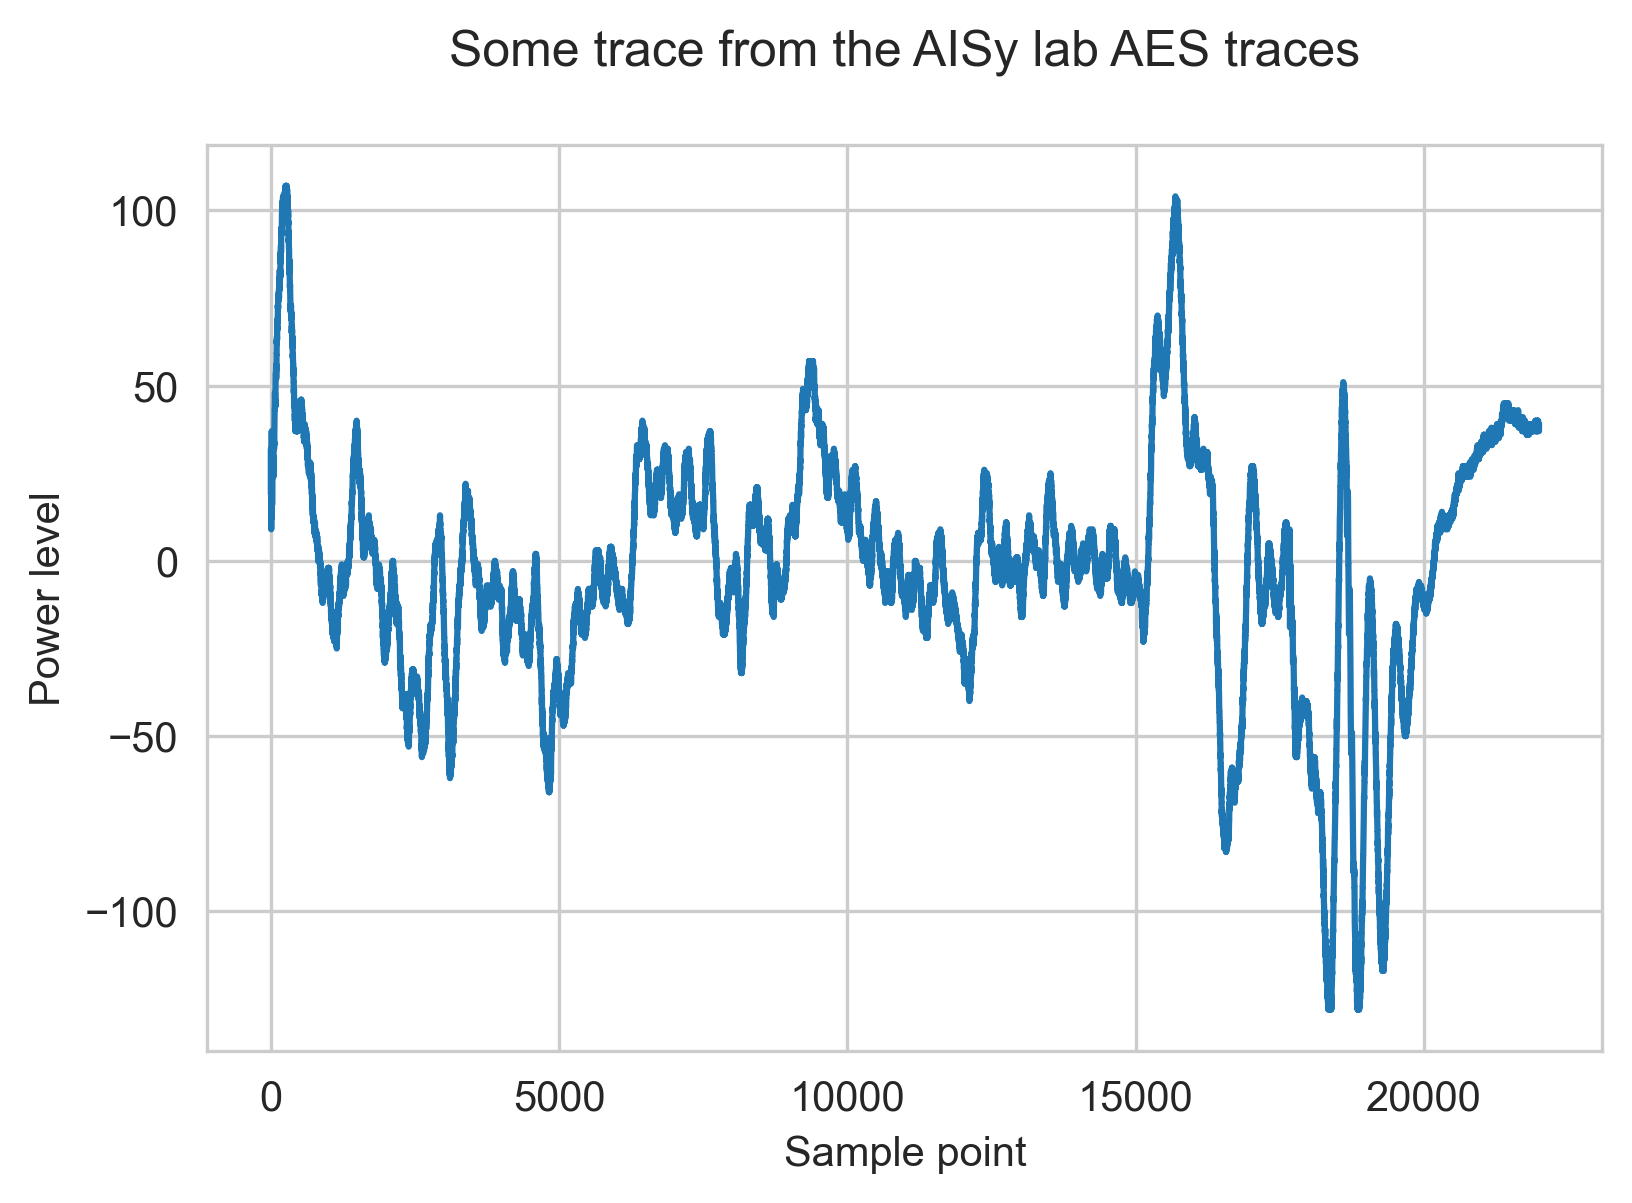

In [26]:
G = sns.lineplot(data=TRACES[0])
G.set(ylabel="Power level", xlabel="Sample point", title="Some trace from the AISy lab AES traces\n") and None

In [27]:
# A: Low HW
A5 = TRACES[TVLA_BYTE]
# B: Random data
B5 = TRACES[np.invert(TVLA_BYTE)]

## TVLA

With 2 class evaluation. Method of the DL-LA paper.

In [28]:
def mdiff(a, b):
    """
    Calculates the moment difference for all sample points,
    a predictive measure for the performance of an 1st order t-test.
    """
    def get_moment(x: np.array):
        return x.mean(axis=0, dtype=np.float128)

    a1, a2 = random_divide(a)
    _, b2 = random_divide(b)

    mdiff_in = np.abs(get_moment(a1) - get_moment(a2))
    mdiff_out = np.abs(get_moment(a1) - get_moment(b2))

    return mdiff_out - mdiff_in

MDIFF = mdiff(A5, B5)

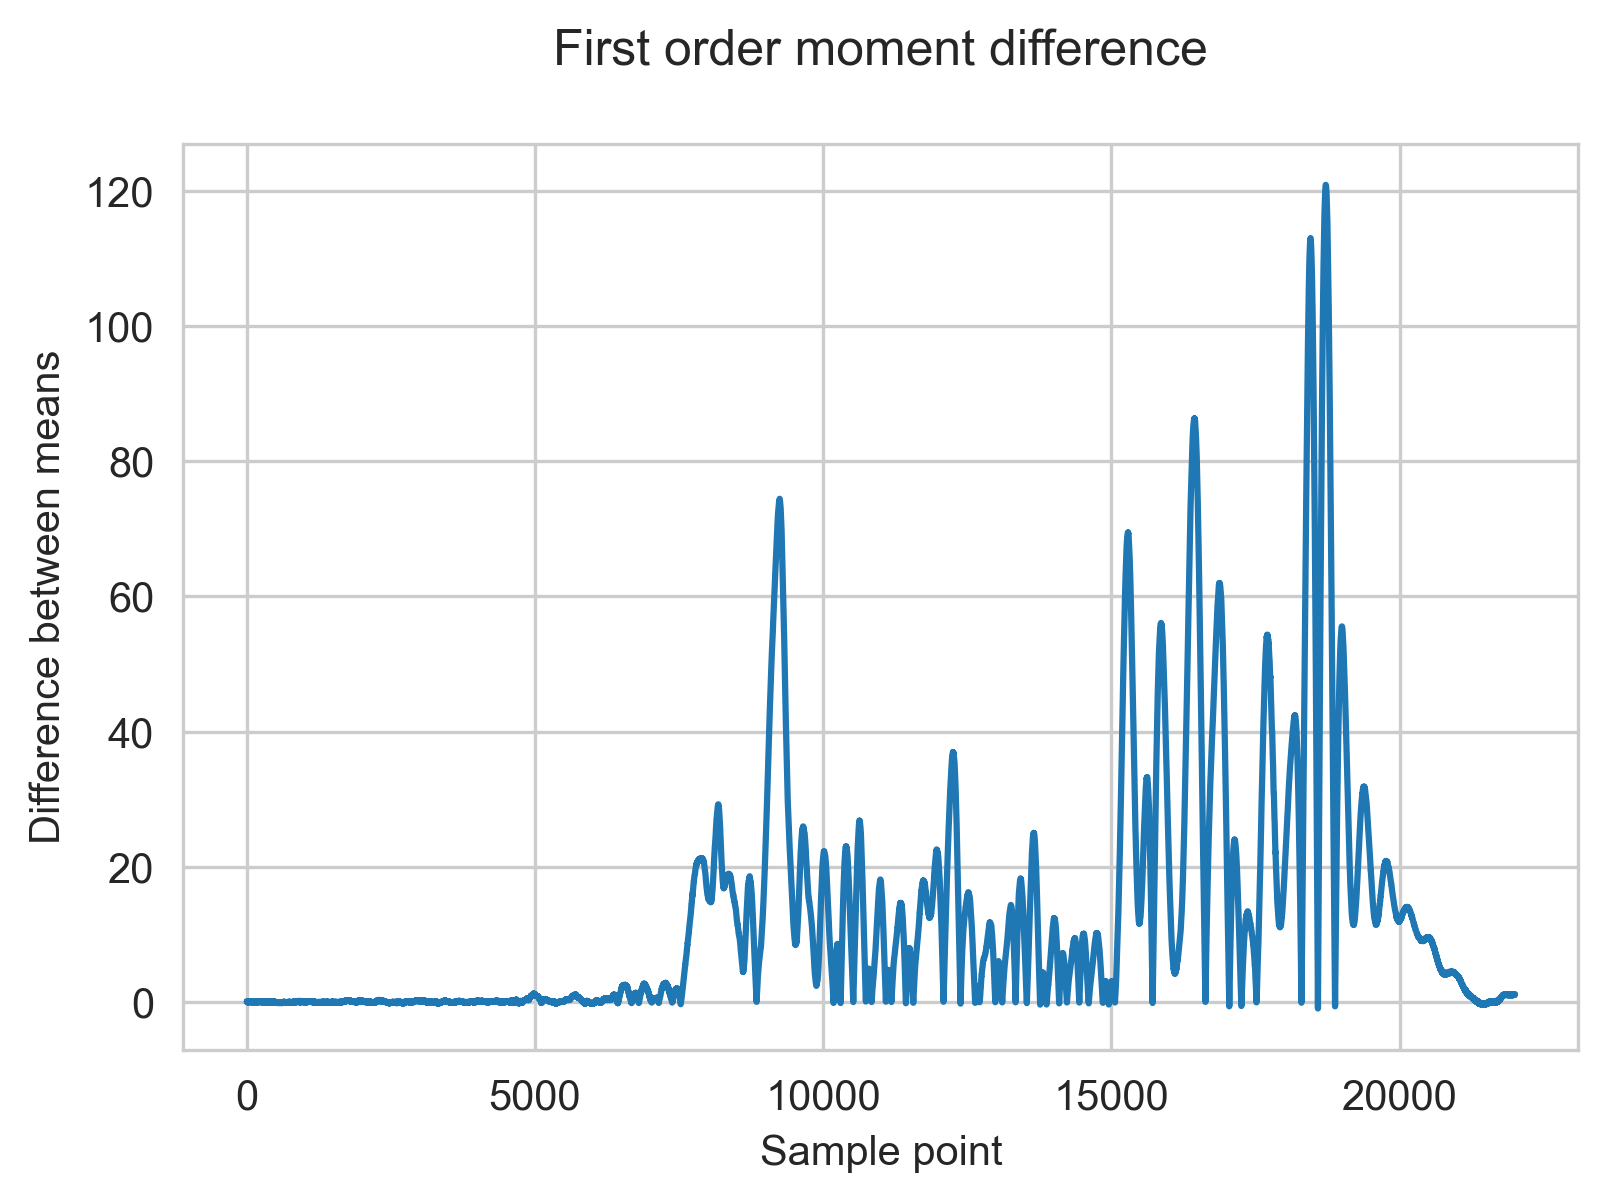

In [29]:

G = sns.lineplot(data=MDIFF)
G.set(ylabel="Difference between means", xlabel="Sample point", title="First order moment difference\n") and None

In [30]:
TITLE = "A: Low hamming weight, B: Random\n"
MAX_TRACES = 100

def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    trace_length = a.shape[1]
    accumulator = Tvla(trace_length, max_order=3)
    accumulator.add(a, b)

    return np.array(accumulator.min_p_gradient)

Computing min-p gradients: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s]


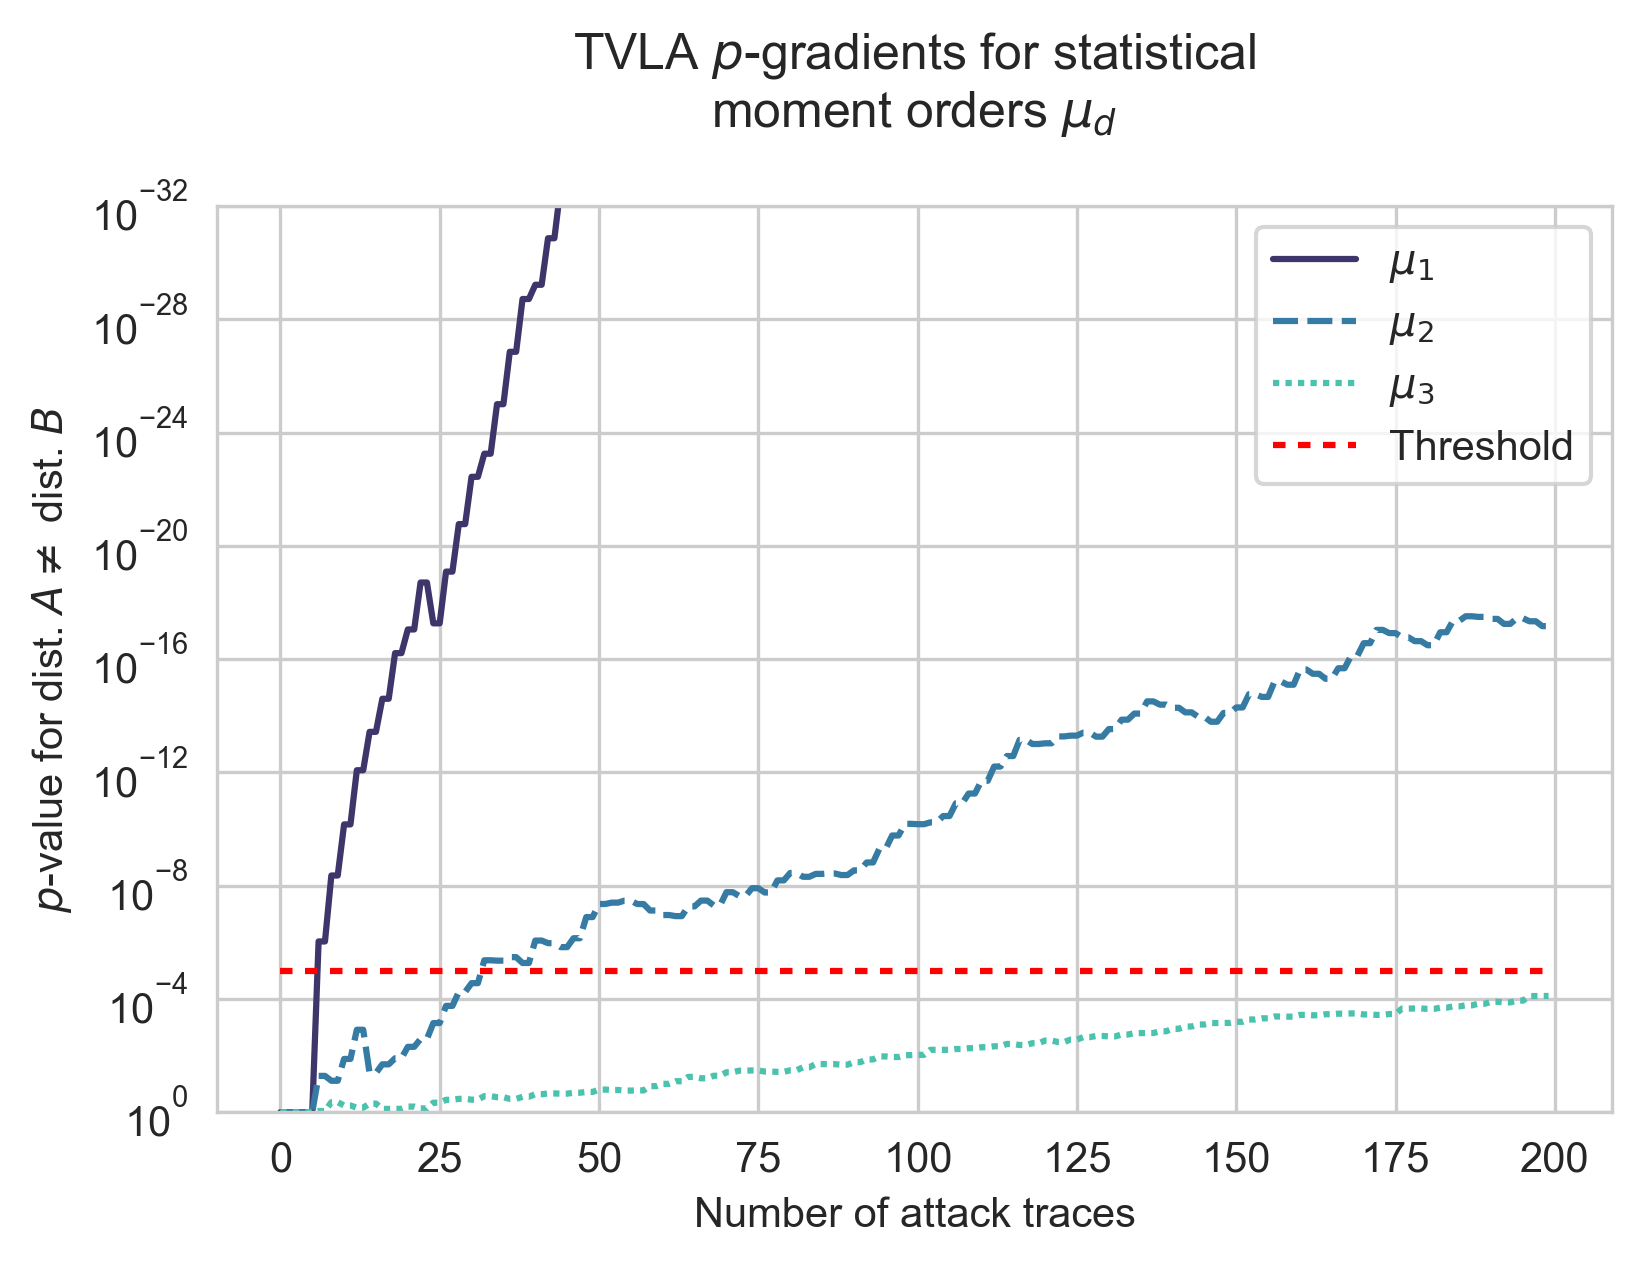

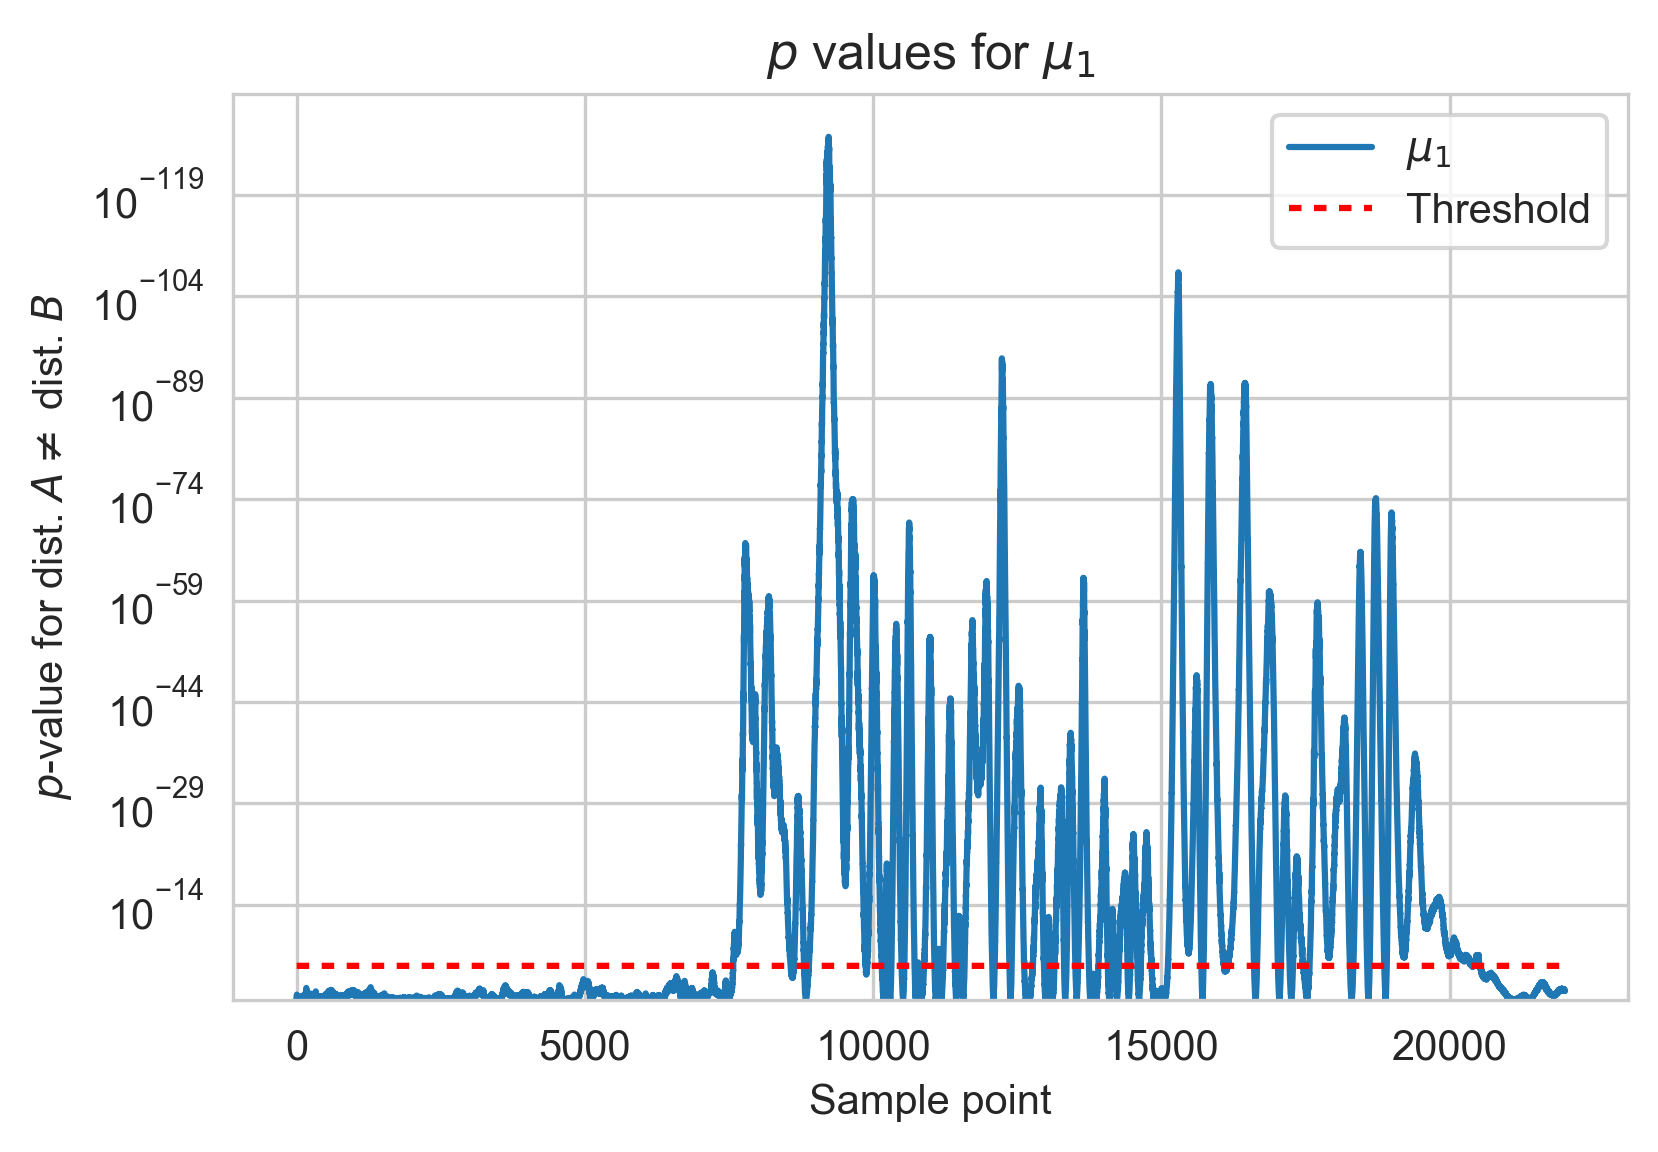

<AxesSubplot:title={'center':'$p$ values for $\\mu_{1}$'}, xlabel='Sample point', ylabel='$p$-value for dist. $A \\neq$ dist. $B$'>

In [31]:
import numpy as np
from numpy.random import binomial

from src.trace_set.set_hw import TraceSetHW
from src.trace_set.transform import fixed_fixed
from src.tvla.tvla import Group
from numpy import logical_and as and_


def tvla_cri(trace_set: TraceSetHW, max_order=4, progress=False):
    x, y = fixed_fixed(*trace_set.all())
    m = binomial(1, .5, len(x))  # Mask

    a1, a2 = x[and_(m, ~y)], x[and_(~m, ~y)]
    b1, b2 = x[and_(m, y)], x[and_(~m, y)]

    ga1, ga2 = Group(a1, max_order, progress), Group(a2, max_order, progress)
    gb1, gb2 = Group(b1, max_order, progress), Group(b2, max_order, progress)

    p = np.ones((max_order + 1, x.shape[1]))

    for order in range(1, max_order + 1):
        _, p1 = ga1.t_test(gb1, order)
        _, p2 = ga2.t_test(gb2, order)

        p[order] = np.max((p1, p2), axis=0)

    return p



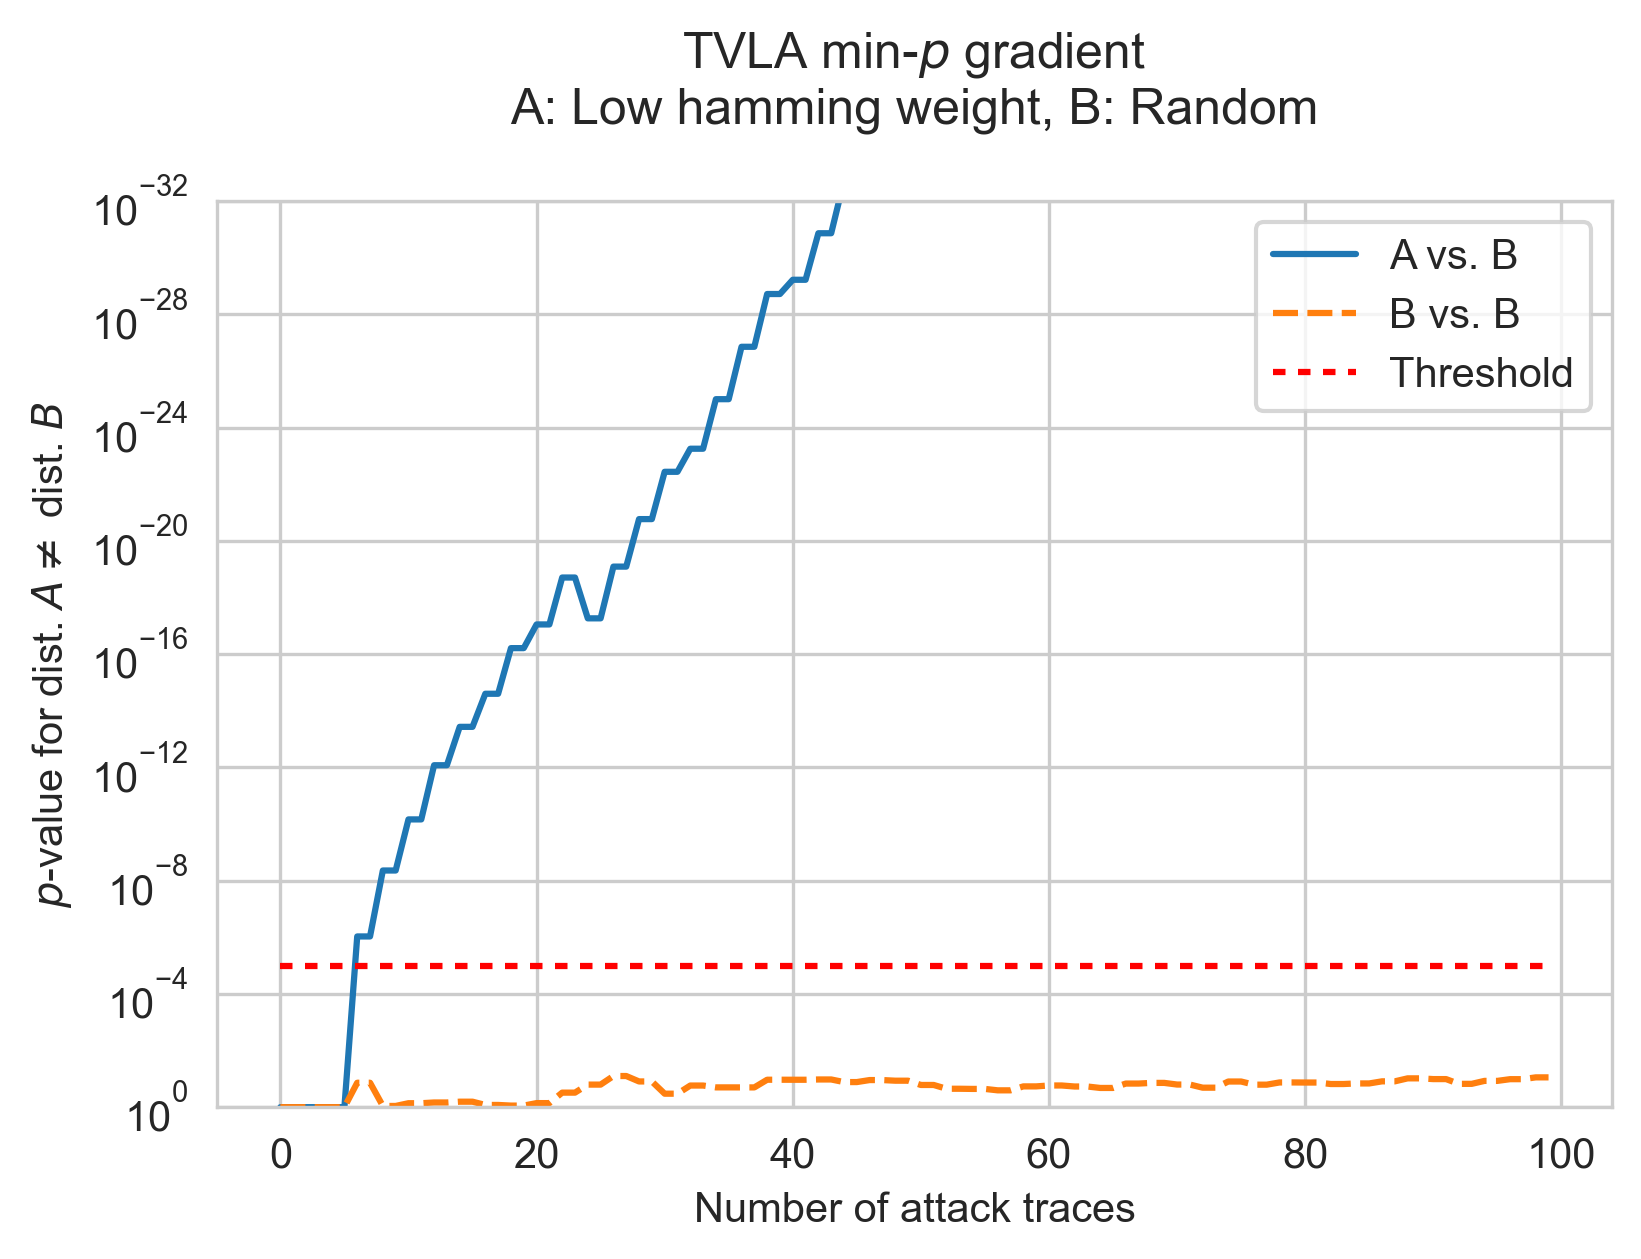

In [32]:
ORDER = 1
plot_p_gradient({"A vs. B": ACC_AB.p_gradient(1), "B vs. B": ACC_BB.p_gradient(1)}, f"TVLA min-$p$ gradient\n{TITLE}", MAX_TRACES)

## 2-class training

With 2 class evaluation

In [33]:
AB_DLLA_WEGENER = prepare_dlla(*labelize((A5, B5)))
MDL_WEGENER_AB = make_mlp_wegener(*AB_DLLA_WEGENER[:2])

KeyboardInterrupt: 

In [ ]:
BB_DLLA_WEGENER = prepare_dlla(*labelize(random_divide(B5)))
MDL_WEGENER_BB = make_mlp_wegener(*BB_DLLA_WEGENER[:2])

In [ ]:
AB_PG_WEGENER = wegener_p_gradient(MDL_WEGENER_AB, *AB_DLLA_WEGENER[2:])
BB_PG_WEGENER = wegener_p_gradient(MDL_WEGENER_BB, *BB_DLLA_WEGENER[2:])

In [ ]:
plot_p_gradient({"A vs. B": AB_PG_WEGENER, "B vs. B": BB_PG_WEGENER}, f"DL-LA $p$-gradient for $z$-test\n{TITLE}", MAX_TRACES)

## 9-class training

With 2 class evaluation

In [ ]:
def hw_byte(plaintexts: np.array, keys: np.array, aes_round=4, target_byte=0):
    """
    Returns the hamming weight of the AES state at the given round and target byte indices.
    """
    states = full_states_hw(plaintexts, keys)

    return states[:, aes_round, target_byte]

HAMMING_WEIGHTS = hw_byte(PLAINTEXT, KEY)

G = sns.lineplot(data={
    "A (low)": np.bincount(HAMMING_WEIGHTS[TVLA_BYTE], minlength=9),
    "B (random)": np.bincount(HAMMING_WEIGHTS[np.invert(TVLA_BYTE)], minlength=9)
})
G.set(title="Distribution of hamming weights\n", xlabel="Hamming Weight", ylabel="Number of traces") and None

In [ ]:
def prepare_dlla_9cls(traces, hamming_weights):
    """
    Prepares traces for usage in 9 class training.
    """
    ab = prepare_dlla(traces, hamming_weights, 9)

    hws_random = hamming_weights.copy()
    np.random.shuffle(hws_random)
    bb = prepare_dlla(traces, hws_random, 9)

    return ab, bb

AB_DLLA, BB_DLLA = prepare_dlla_9cls(TRACES, HAMMING_WEIGHTS)

In [ ]:
def make_mlp(x, y):
    mdl = Sequential()
    mdl.add(Dense(100, activation='relu', input_shape=(TRACE_LEN,)))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(9, activation='softmax'))

    mdl.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics='accuracy')

    mdl.fit(x, y, shuffle=True, batch_size=150, epochs=1, verbose=True)

    return mdl

In [ ]:
MODEL_AB = make_mlp(*AB_DLLA[:2])
MODEL_BB = make_mlp(*BB_DLLA[:2])

In [ ]:
dlla_hw(MODEL_AB, *AB_DLLA[2:])

AB_PG = dlla_p_gradient(MODEL_AB, *AB_DLLA[2:])
BB_PG = dlla_p_gradient(MODEL_BB, *BB_DLLA[2:])

In [ ]:
plot_p_gradient({"A vs. B": AB_PG["A vs. B"], "B vs. B": BB_PG["A vs. B"]}, f"DL-LA $p$-gradient\n{TITLE}", 1000)

In [ ]:
plot_p_gradient({"DL-LA 9-class": AB_PG["A vs. B"],
                 "DL-LA Wegener": AB_PG_WEGENER,
                 "TVLA ($t$-test, $\mu_1$, min-$p$)": ACC_AB.p_gradient(1), },
                f"$p$-gradients for AES without countermeasures", MAX_TRACES,
                file_name="aisy-all")

dlla_p_gradient(MODEL_AB, *AB_DLLA[2:])
